In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=843659d2493bca3734deda08b9af0897ebe413a2275e3dc6c9f913e48ba0f545
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torchviz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.autograd import grad
from torch import nn
from torch.utils.data import Dataset
from sklearn.metrics import precision_recall_fscore_support as all_metrics
from sklearn.metrics import accuracy_score

from collections import defaultdict

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [ ]:
sns.set(palette='Set2', font_scale=1.2)
%matplotlib inline

In [ ]:
device = 'cuda'

### Задача 1. Дифференцирование

Для функции

$$ f(x, y, z)=\left(\frac{y^4}{1+e^{-x}}\right)^3 + z$$

С помощью Pytorch:

- постройте вычислительный граф с возможностью считать производные по x, y.

- выведите все узлы полученного графа и их атрибуты (рассмотренные на лекции)

- объясните, почему атрибуты принимают такие значения

Для точки (1, 3, 2):

- посчитайте для функции все возможные первые частные производные методом backward()

- посчитайте для функции все возможные вторые частные производные

In [ ]:
from torchviz import make_dot

In [ ]:
x = torch.tensor(1, requires_grad=True, dtype=torch.float)
y = torch.tensor(3, requires_grad=True, dtype=torch.float)
z = torch.tensor(2, requires_grad=True, dtype=torch.float)

In [ ]:
f = (y ** 4 / (1 + torch.exp(-x))) ** 3 + z

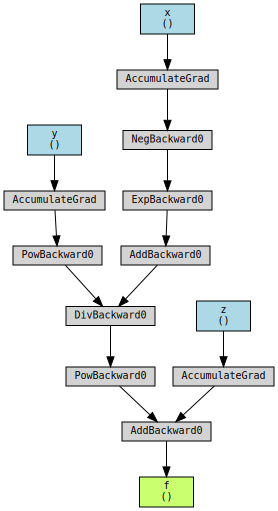

In [ ]:
make_dot(f, params={'x': x, 'y': y, 'z':z, 'f': f})

In [ ]:
x.is_leaf, y.is_leaf, z.is_leaf, f.is_leaf

(True, True, True, False)

In [ ]:
x.requires_grad, y.requires_grad, z.requires_grad, f.requires_grad

(True, True, True, True)

In [ ]:
print(y.grad)

None


атрибут requires_grad принимает такое значение (тру) т.к. все тензоры добавлены к вычислительному графу, при создании x,y,z устанавливался параметр requires_grad=True; атрибут is_leaf True для переменных x,y,z функции, т.к они являются листами вычислительного графа (как и все переменные созданные пользователем, а не в результате арифм операций(такие - промежуточные)), атрибут grad хранит градиент тензора, с дефолтным значением None до вызова .backwards()

In [ ]:
f.backward(retain_graph=True, create_graph=True)

In [ ]:
print('Первые частные производные:')
print(f"∂f/∂x: {x.grad}")
print(f"∂f/∂y: {y.grad}")
print(f"∂f/∂z: {z.grad}")

Первые частные производные:
∂f/∂x: 167529.25
∂f/∂y: 830561.25
∂f/∂z: 1.0


In [ ]:
partial_x = x.grad
partial_y = y.grad
partial_z = z.grad

In [ ]:
x.grad.data.zero_(), y.grad.data.zero_(), z.grad.data.zero_()
partial_x.backward(retain_graph=True, create_graph=True)

In [ ]:
print(f"∂²f/∂x²: {x.grad}")
print(f"∂²f/∂x∂y: {y.grad}")
print(f"∂²f/∂x∂z: {z.grad}")

∂²f/∂x²: 12692.9794921875
∂²f/∂x∂y: 670117.0
∂²f/∂x∂z: 0.0


In [ ]:
x.grad.data.zero_(), y.grad.data.zero_(), z.grad.data.zero_()
partial_y.backward(retain_graph=True, create_graph=True)

In [ ]:
print(f"∂²f/∂y∂x: {x.grad}")
print(f"∂²f/∂y²: {y.grad}")
print(f"∂²f/∂y∂z: {z.grad}")

∂²f/∂y∂x: 670117.0
∂²f/∂y²: 3045391.0
∂²f/∂y∂z: 0.0


In [ ]:
print(f"∂²f/∂z∂x: {x.grad}")
print(f"∂²f/∂z∂y: {y.grad}")
print(f"∂²f/∂z²: {z.grad}")

∂²f/∂z∂x: 0.0
∂²f/∂z∂y: 0.0
∂²f/∂z²: 0.0


#### Профиль биология

Скачайте [датасет](https://disk.yandex.ru/d/FVoQGn5q1td7Vw), описывающий влияние курения и алкоголя на человека. Создайте и обучите нейросеть, разделяющую эти два класса.

[Описание датасета](https://www.kaggle.com/datasets/sooyoungher/smoking-drinking-dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/smoking_driking_dataset_Ver01.csv')
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


Проанализируйте датасет, разделяя его по:
* курит &mdash; 3
* курил, но бросил &mdash; 2
* никогда не курил &mdash; 1

In [ ]:

df.groupby('SMK_stat_type_cd').describe()

age                                                \
                     count       mean        std   min   25%   50%   75%   
SMK_stat_type_cd                                                           
1.0               602441.0  48.455401  14.830668  20.0  40.0  50.0  60.0   
2.0               174951.0  50.112632  12.996934  20.0  40.0  50.0  60.0   
3.0               213954.0  43.203960  12.159067  20.0  35.0  40.0  50.0   

                          height              ... SGOT_ALT         gamma_GTP  \
                   max     count        mean  ...      75%     max     count   
SMK_stat_type_cd                              ...                              
1.0               85.0  602441.0  158.572582  ...     26.0  7210.0  602441.0   
2.0               85.0  174951.0  167.382296  ...     35.0  3307.0  174951.0   
3.0               85.0  213954.0  168.364555  ...     35.0  4633.0  213954.0   

                                                                      
                       mean        std  min   25%   50%   75%    max  
SMK_stat_type_cd                                                      
1.0               27.426485  34.570514  1.0  14.0  19.0  29.0  999.0  
2.0               47.043515  56.614068  1.0  21.0  31.0  52.0  999.0  
3.0               56.375763  71.267921  1.0  23.0  36.0  62.0  999.0  

[3 rows x 168 columns]

In [ ]:
df.groupby('SMK_stat_type_cd').describe().loc[:, (slice(None), 'mean')]

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,...,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
SMK_stat_type_cd,,,,,,,,,,,,,,,,,,,,,
1.0,48.455401,158.572582,59.306272,79.001125,0.949829,0.946845,1.032956,1.032227,121.177911,74.916407,...,195.336906,59.258090,113.364130,115.055730,13.638717,1.087614,0.803322,24.680925,22.813524,27.426485
2.0,50.112632,167.382296,69.406891,85.312877,1.013957,1.013486,1.038639,1.036216,125.345011,78.059588,...,194.951243,53.824900,112.836686,147.418752,14.967969,1.108768,0.965003,28.196804,29.959320,47.043515
3.0,43.203960,168.364555,69.477808,84.182930,1.041053,1.038697,1.021537,1.020850,123.583527,77.610842,...,196.672154,52.945241,112.282888,167.759654,15.290647,1.100947,0.935891,27.868313,30.599811,56.375763


In [ ]:
df.describe()

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,...,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd
count,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,...,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000,991346.000000
mean,47.614491,162.240625,63.284050,81.233358,0.980834,0.978429,1.031495,1.030476,122.432498,76.052627,...,56.936800,113.037692,132.141751,14.229824,1.094224,0.860467,25.989308,25.755051,37.136347,1.608122
std,14.181339,9.282957,12.514241,11.850323,0.605949,0.604774,0.174650,0.171892,14.543148,9.889365,...,17.238479,35.842812,102.196985,1.584929,0.437724,0.480530,23.493386,26.308599,50.424153,0.818507
min,20.000000,130.000000,25.000000,8.000000,0.100000,0.100000,1.000000,1.000000,67.000000,32.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,1.000000
25%,35.000000,155.000000,55.000000,74.100000,0.700000,0.700000,1.000000,1.000000,112.000000,70.000000,...,46.000000,89.000000,73.000000,13.200000,1.000000,0.700000,19.000000,15.000000,16.000000,1.000000
50%,45.000000,160.000000,60.000000,81.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,...,55.000000,111.000000,106.000000,14.300000,1.000000,0.800000,23.000000,20.000000,23.000000,1.000000
75%,60.000000,170.000000,70.000000,87.800000,1.200000,1.200000,1.000000,1.000000,131.000000,82.000000,...,66.000000,135.000000,159.000000,15.400000,1.000000,1.000000,28.000000,29.000000,39.000000,2.000000
max,85.000000,190.000000,140.000000,999.000000,9.900000,9.900000,2.000000,2.000000,273.000000,185.000000,...,8110.000000,5119.000000,9490.000000,25.000000,6.000000,98.000000,9999.000000,7210.000000,999.000000,3.000000


Попробуем классифицировать людей с плохими привычками и без них. Для этого создайте дополнительный столбец в таблице, который будет содержать информацию о том, имеет ли человек вредные привычки или нет.

In [ ]:
def smoking(status):
    return 1 if status in [2, 3] else 0

def drinking(status):
    return 1 if status == 'Y' else 0

df['SMK_stat_type_cd'] = df['SMK_stat_type_cd'].apply(smoking)
df['DRK_YN'] = df['DRK_YN'].apply(drinking)
df['bad_habits'] = df['DRK_YN'] + df['SMK_stat_type_cd'] - (df['DRK_YN'] * df['SMK_stat_type_cd'])

In [ ]:
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN,bad_habits
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,92.0,17.1,1.0,1.0,21.0,35.0,40.0,0,1,1
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,121.0,15.8,1.0,0.9,20.0,36.0,27.0,1,0,1
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,104.0,15.8,1.0,0.9,47.0,32.0,68.0,0,0,0
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,106.0,17.6,1.0,1.1,29.0,34.0,18.0,0,0,0
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,104.0,13.8,1.0,0.8,19.0,12.0,25.0,0,0,0


Теперь смотрим на разделение по привычкам

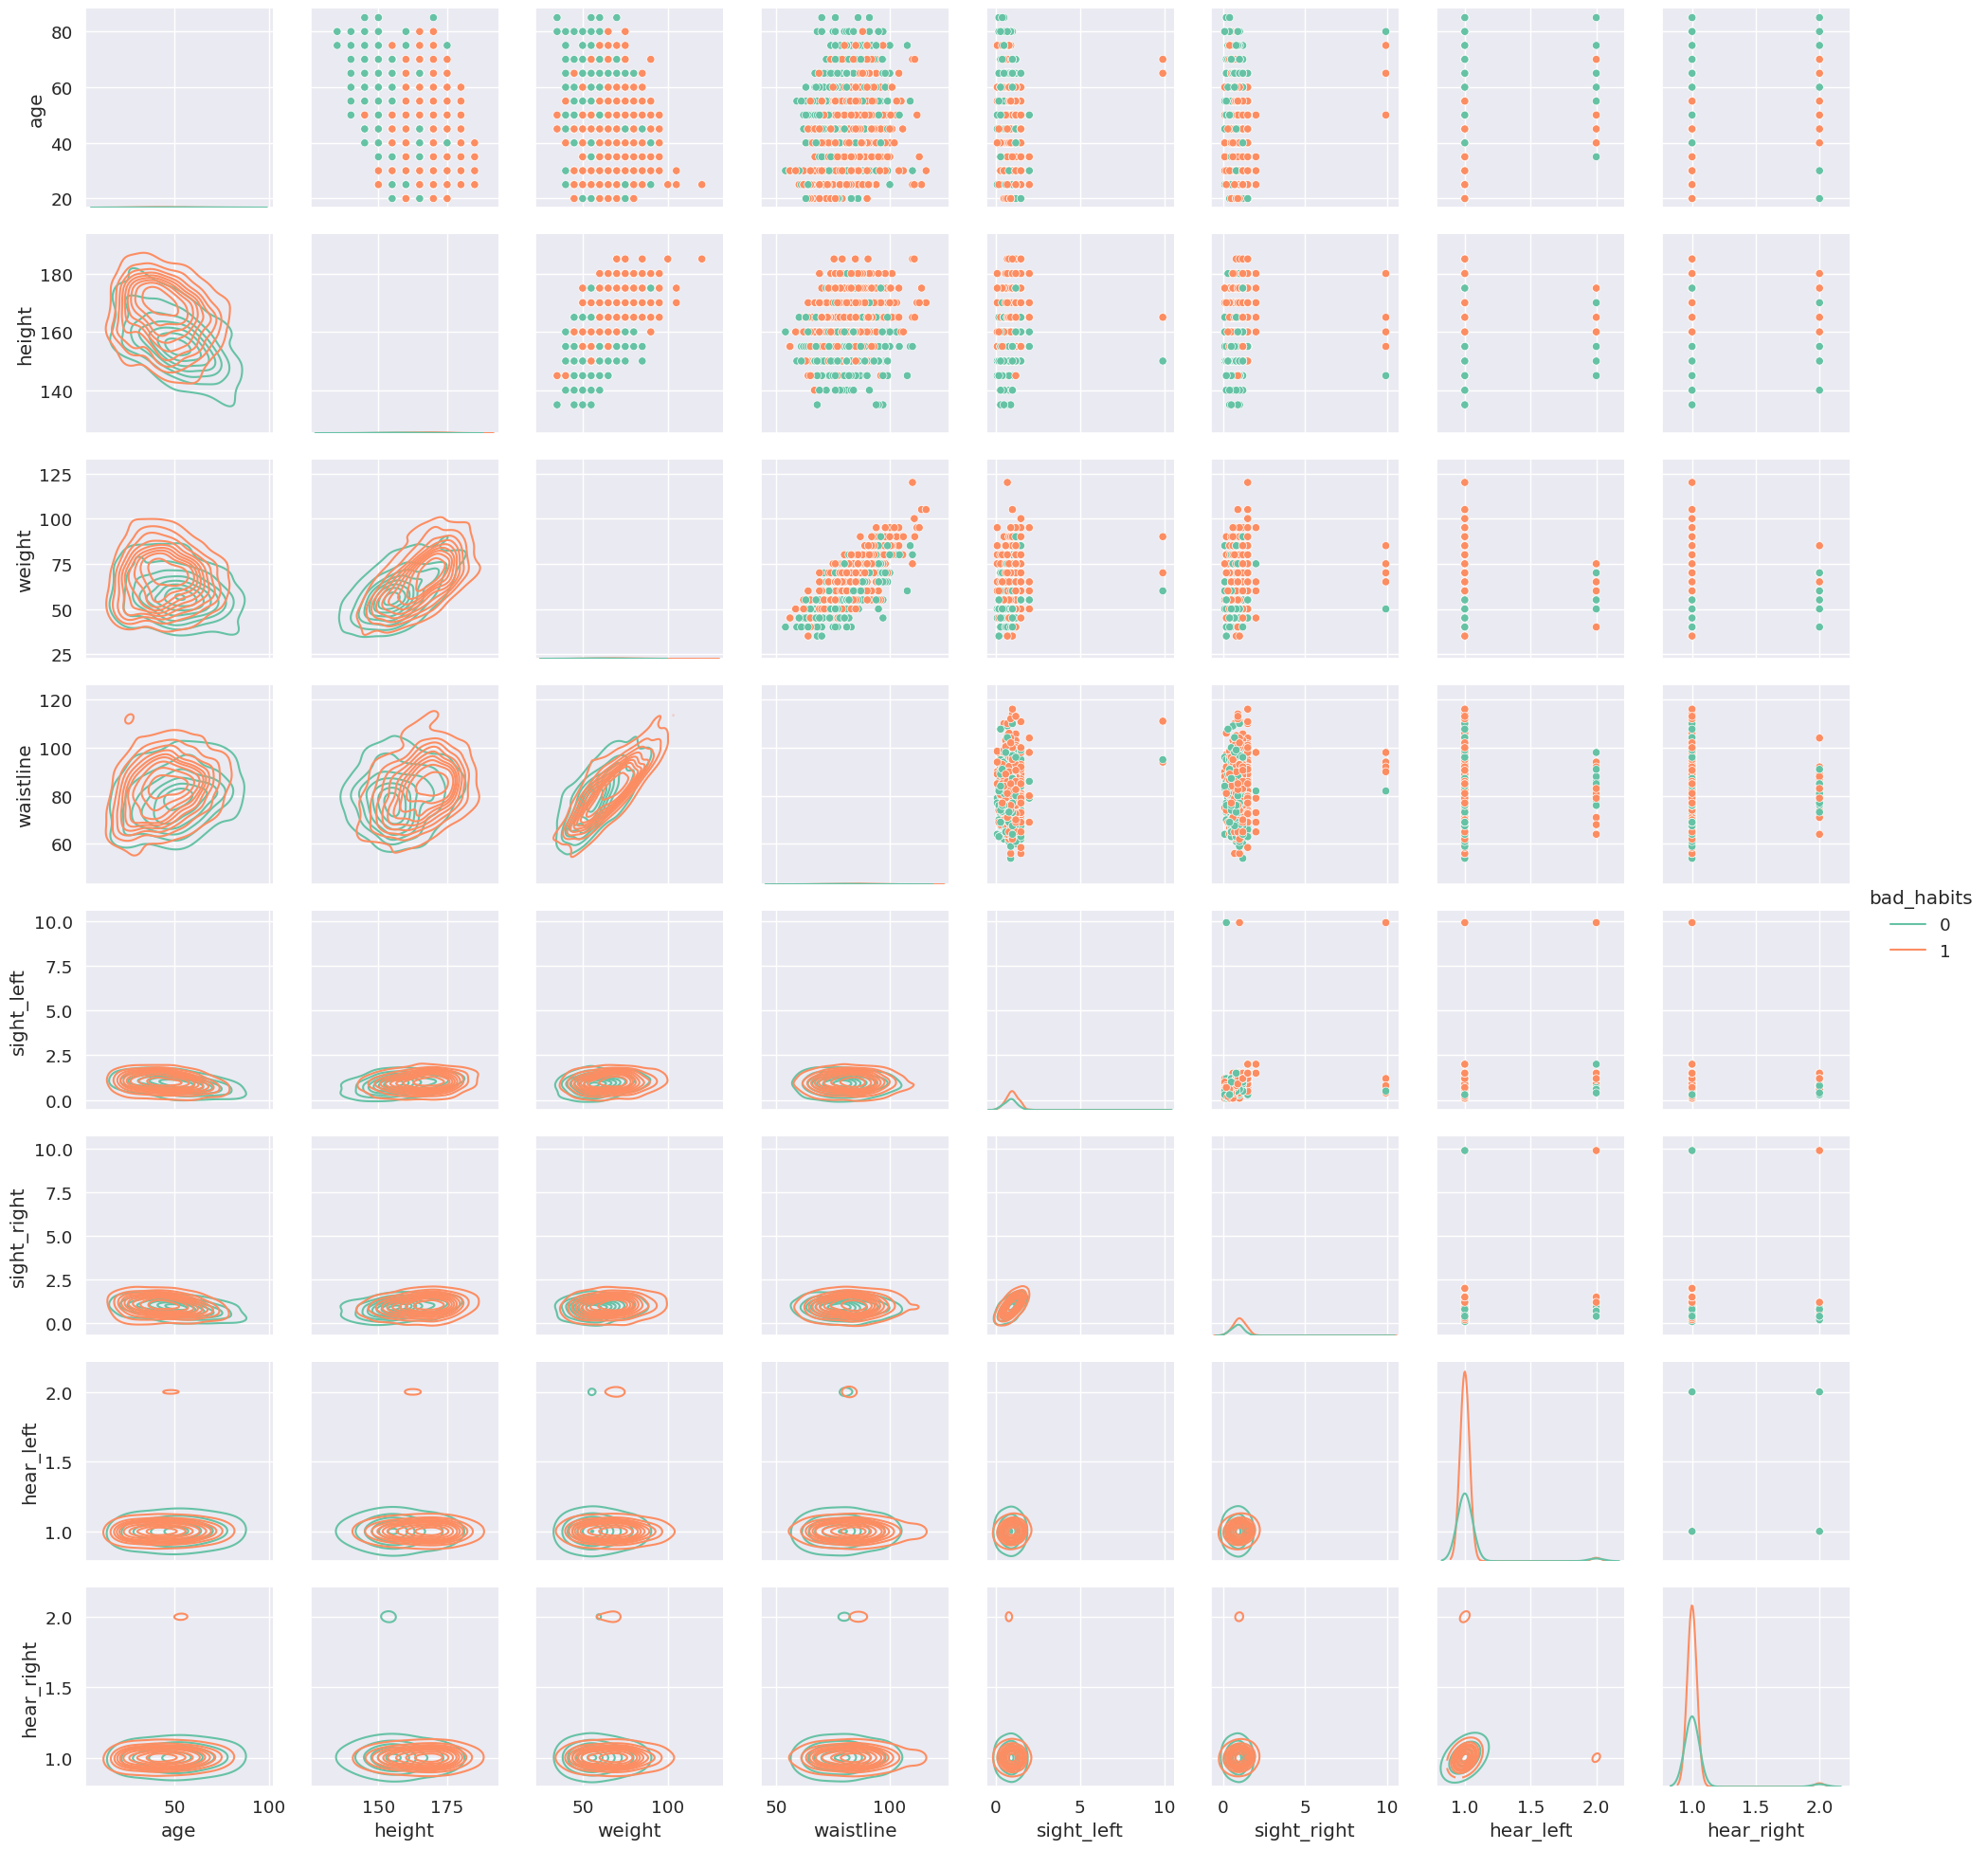

In [ ]:
graph = sns.PairGrid(df.iloc[:1000], hue='bad_habits', vars = df.columns[1:9])
graph.map_upper(sns.scatterplot)
graph.map_lower(sns.kdeplot)
graph.map_diag(sns.kdeplot)
graph.add_legend()

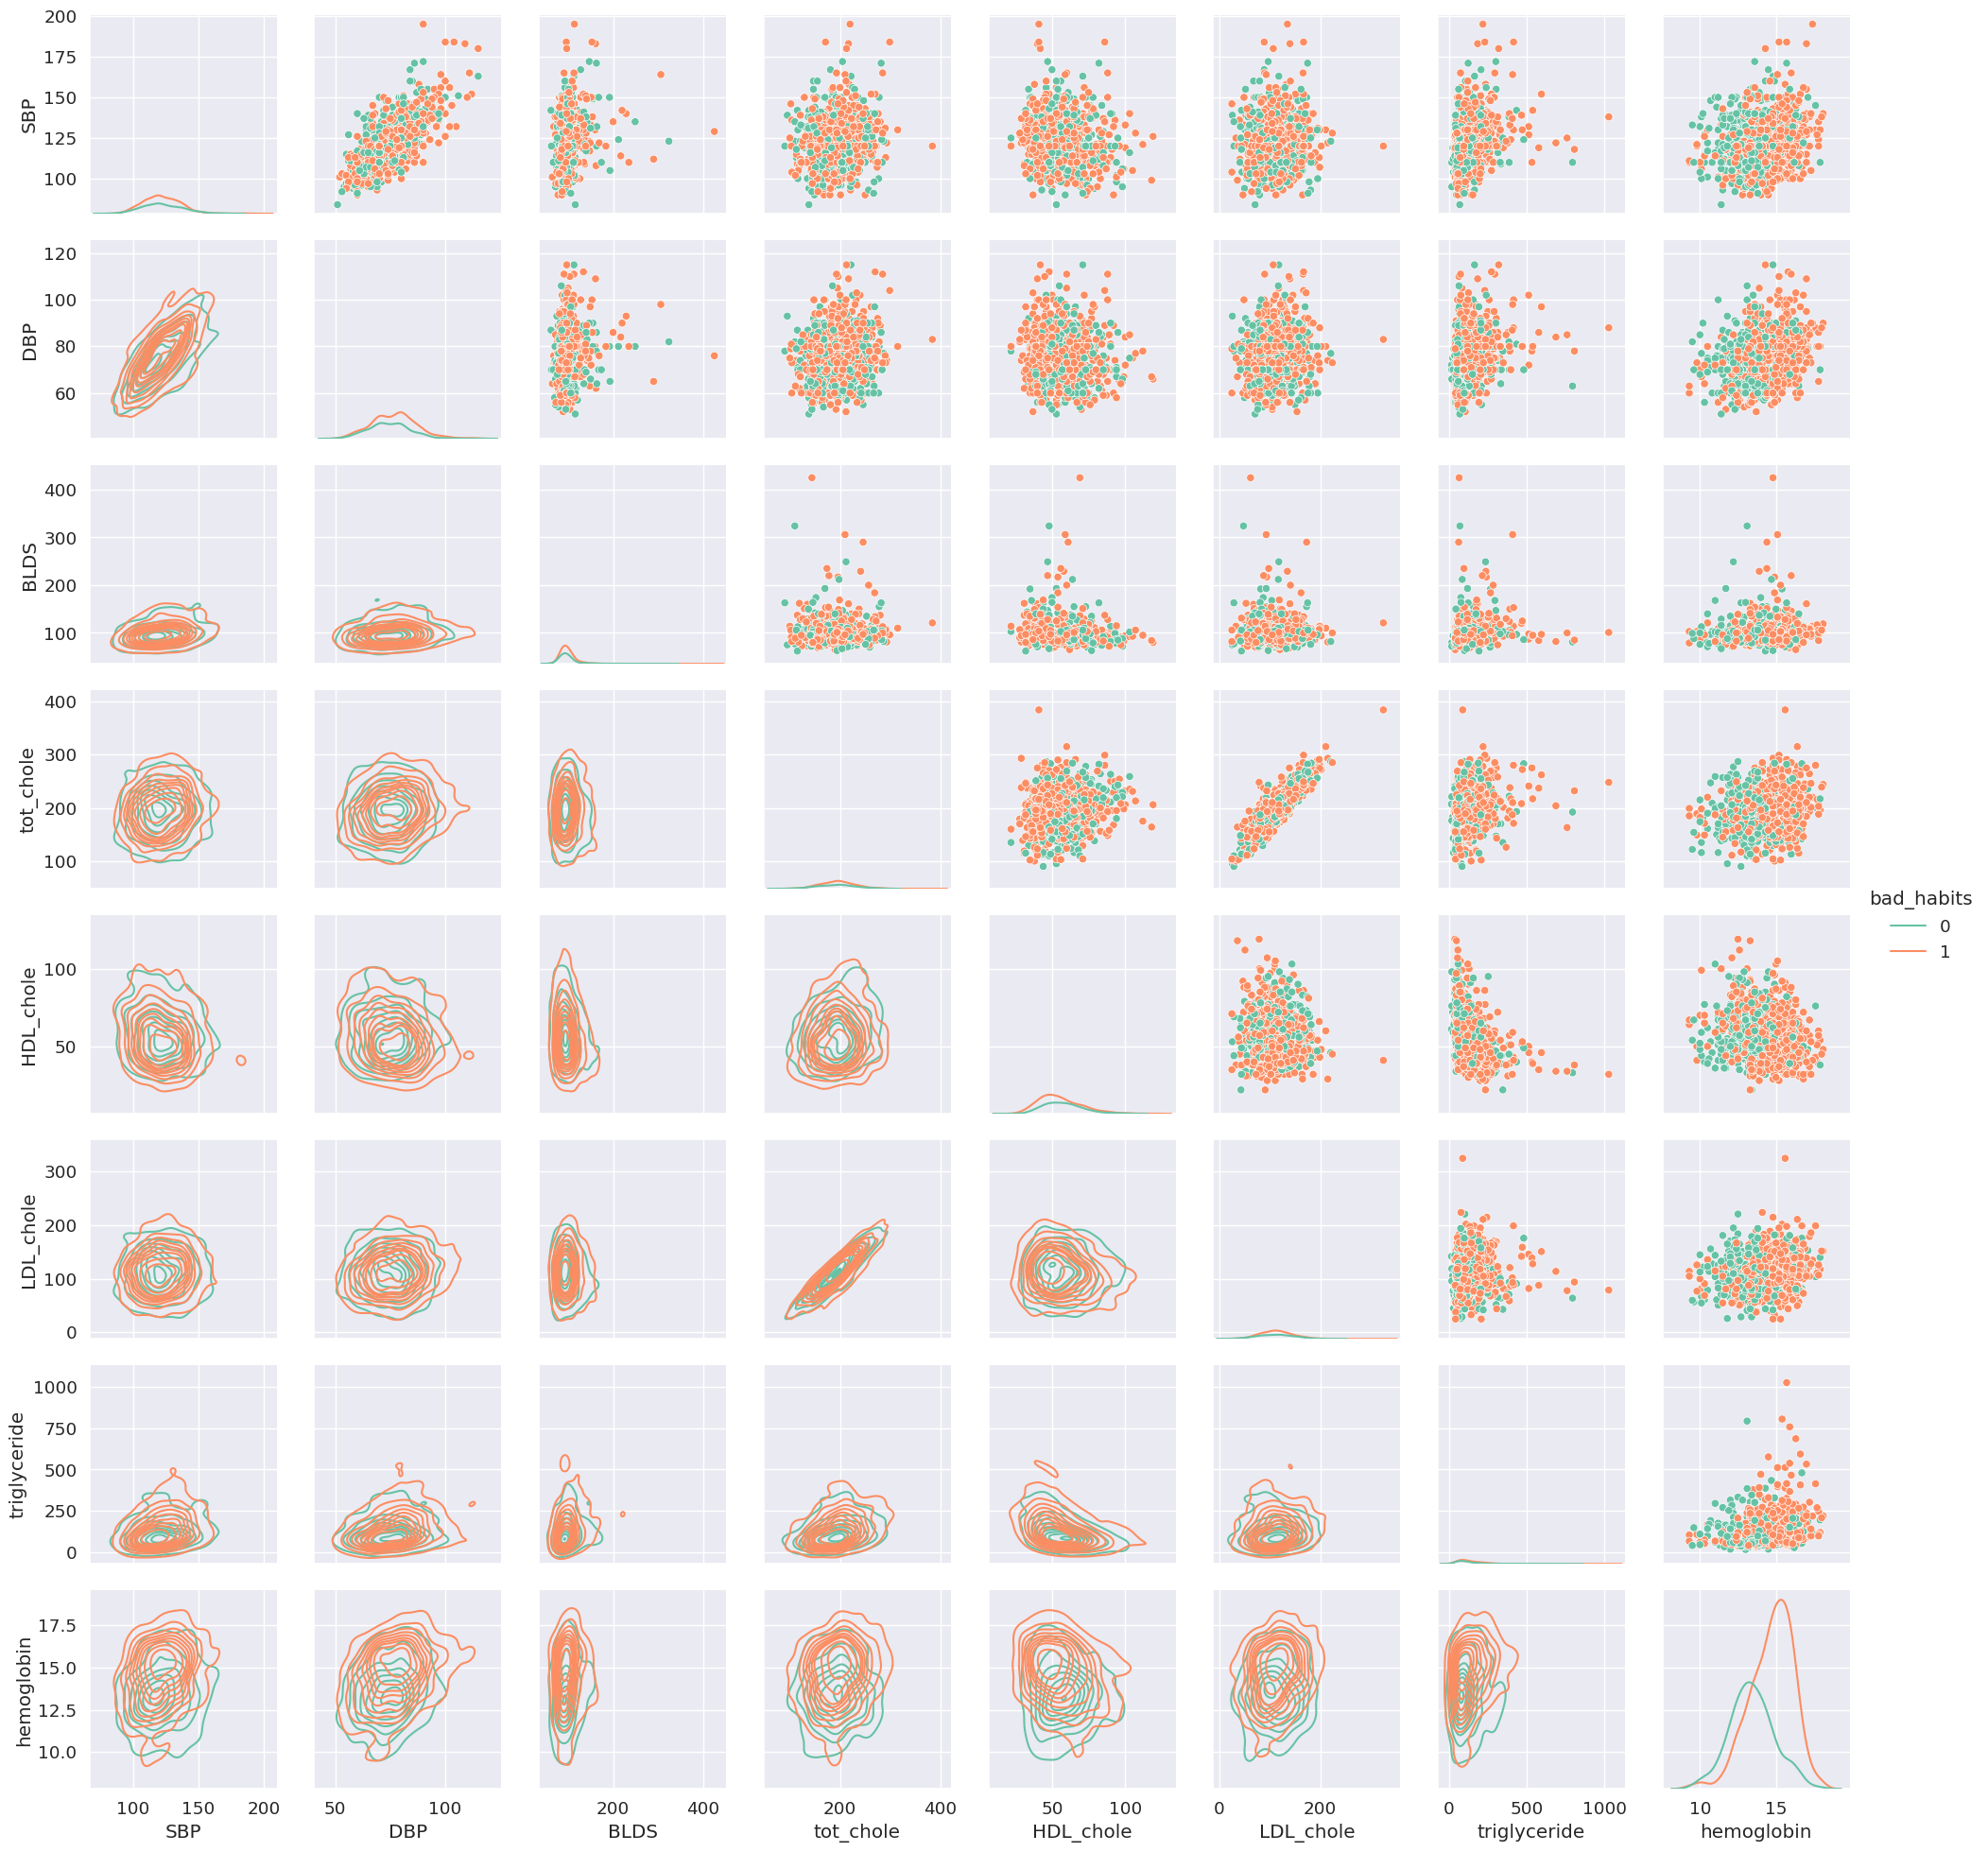

In [ ]:
graph = sns.PairGrid(df.iloc[:1000], hue='bad_habits', vars = df.columns[9:17])
graph.map_upper(sns.scatterplot)
graph.map_lower(sns.kdeplot)
graph.map_diag(sns.kdeplot)
graph.add_legend()

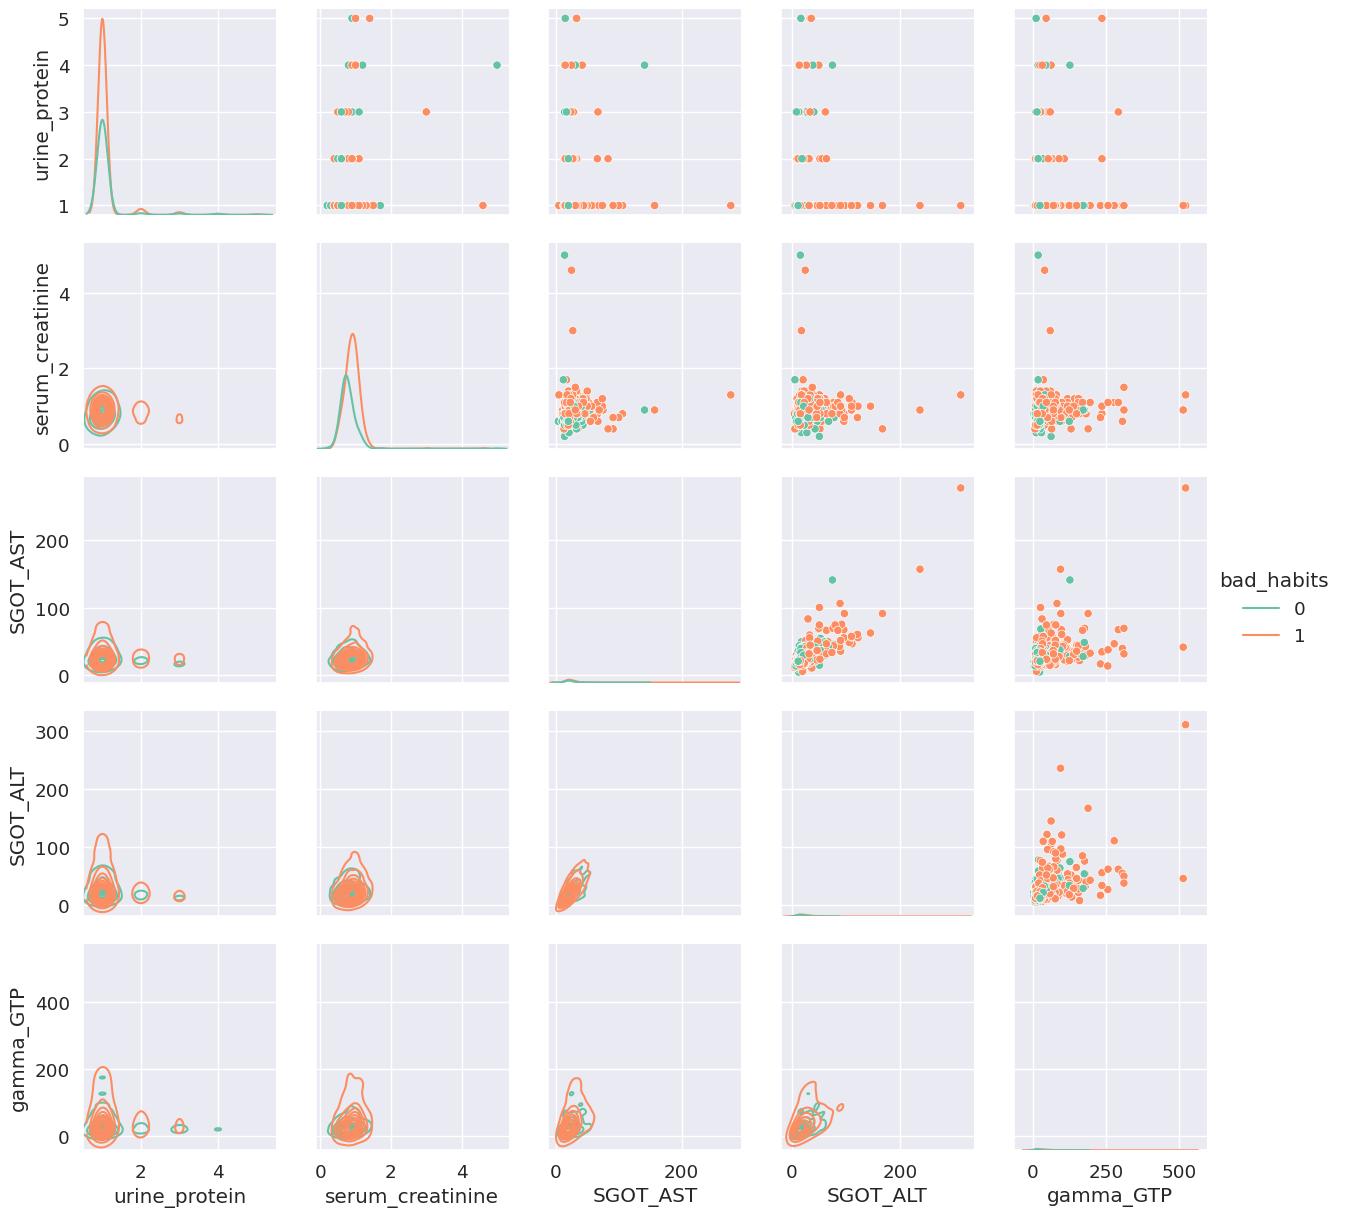

In [ ]:
graph = sns.PairGrid(df.iloc[:1000], hue='bad_habits', vars = df.columns[17:22])
graph.map_upper(sns.scatterplot)
graph.map_lower(sns.kdeplot)
graph.map_diag(sns.kdeplot)
graph.add_legend()

In [ ]:
df.loc[df['bad_habits'] == 0]

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN,bad_habits
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,104.0,15.8,1.0,0.9,47.0,32.0,68.0,0,0,0
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,106.0,17.6,1.0,1.1,29.0,34.0,18.0,0,0,0
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,104.0,13.8,1.0,0.8,19.0,12.0,25.0,0,0,0
6,Female,45,150,55,69.0,0.5,0.4,1.0,1.0,101.0,...,75.0,12.3,1.0,0.8,19.0,12.0,12.0,0,0,0
10,Male,45,155,55,79.2,1.0,1.0,1.0,1.0,118.0,...,55.0,12.9,1.0,0.8,19.0,14.0,19.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991337,Female,35,165,70,81.0,1.0,1.0,1.0,1.0,113.0,...,88.0,13.3,1.0,0.7,20.0,17.0,12.0,0,0,0
991340,Female,50,150,50,72.6,1.0,1.0,1.0,1.0,116.0,...,125.0,15.2,1.0,0.8,28.0,26.0,29.0,0,0,0
991341,Male,45,175,80,92.1,1.5,1.5,1.0,1.0,114.0,...,132.0,15.0,1.0,1.0,26.0,36.0,27.0,0,0,0
991342,Male,35,170,75,86.0,1.0,1.5,1.0,1.0,119.0,...,45.0,15.8,1.0,1.1,14.0,17.0,15.0,0,0,0


Какие признаки вы бы использовали для разделения людей по классам? Выберите эти столбцы и создайте наборы train и test с помощью функции train_test_split, а также выделите набор данных для валидации при обучении.

In [ ]:
df.groupby('bad_habits').describe().loc[:, (slice(None), 'mean')]

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
bad_habits,,,,,,,,,,,,,,,,,,,,,
0,51.997005,156.674726,57.859772,78.983477,0.917772,0.916746,1.041027,1.040128,121.692162,74.765998,...,114.591558,115.740464,13.436998,1.089062,0.792563,24.755988,22.652281,24.620709,0.000000,0.000000
1,44.784107,165.835281,66.787242,82.686411,1.021563,1.018266,1.025338,1.024242,122.910633,76.883578,...,112.034150,142.734285,14.741859,1.097559,0.904321,26.785830,27.758930,45.219391,0.645661,0.822611


In [ ]:
df_mean = df.groupby('bad_habits').describe().loc[:, (slice(None), 'mean')]
result = df_mean.transpose()
result

,bad_habits,0,1
age,mean,51.997005,44.784107
height,mean,156.674726,165.835281
weight,mean,57.859772,66.787242
waistline,mean,78.983477,82.686411
sight_left,mean,0.917772,1.021563
sight_right,mean,0.916746,1.018266
hear_left,mean,1.041027,1.025338
hear_right,mean,1.040128,1.024242
SBP,mean,121.692162,122.910633
DBP,mean,74.765998,76.883578


In [ ]:
selected_features = ['BLDS', 'SBP', 'LDL_chole', 'SGOT_AST', 'SGOT_ALT', 'weight', 'waistline', 'DBP', 'HDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'gamma_GTP']
X = df[selected_features]

In [ ]:
target = df.pop('bad_habits')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.3)
X_val, X_test, y_val, y_test  = train_test_split(X_test, y_test, train_size=0.3)

In [ ]:
class_lim_proba = 0.5 # критерий принадлежности к тому или иному классу

Стандартизируйте данные

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Далее сформируйте датасет в pytorch-обертке

In [ ]:
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test.values)
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train.values)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val.values)

Напишите вспомогательные функции, в одной из которых будет проходить обучение, а во вторй - валидация. Также в отдельной функцией можно описать отрисовку кривых обучения. На одном графике расположите значение функции потерь на трейне и валидации, а на другом -- значение метрики качества на ваш выбор, также для трейна и валидации)

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для отображения лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20,7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()


def train_epoch(model, criterion, optimizer, train_loader, device):
    '''
    Проход по данным для обучения в одной эпохе
    '''
    train_loss = 0
    train_acc = 0

    model.train(True)  # устанавливаем поведение dropout / batch_norm  в обучение

    # На каждой "эпохе" делаем полный проход по данным
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Обучаемся на батче (одна "итерация" обучения нейросети)
        logits = model(X_batch)

        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.detach().cpu().numpy()
        y_pred_np = np.argmax(logits.detach().cpu().numpy(), axis=1)
        y_batch_np = y_batch.cpu().numpy()
        train_acc += (y_batch_np == y_pred_np).sum()

    # Подсчитываем лоссы
    train_loss /= num_train_batches
    train_acc /= num_train_batches * batch_size

    return train_loss, train_acc


def test_epoch(model, criterion, val_loader, device):
    '''
    Валидация на одной эпохе
    '''
    model.eval()
    val_loss = 0
    val_acc = 0
    val_size = 0
    # Полный проход по валидации
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            val_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, axis=1).detach()
            val_acc += (y_batch == y_pred).sum()
            val_size += len(y_batch)

    # Подсчитываем лоссы
    val_loss = val_loss.cpu().numpy() / val_size
    val_acc = val_acc.cpu().numpy() / val_size

    return val_loss, val_acc

Создание модели

In [ ]:
X_train.shape

torch.Size([297403, 13])

In [ ]:
y_test.shape

torch.Size([485761])

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self):

        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(13, 13)
        self.linear2 = nn.Linear(13, 3)
        self.linear3 = nn.Linear(3, 2)

    def forward(self, x):

        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.Tanh()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

Обучение

In [ ]:
class SimpleDataset():
    """
    Простой итерируемый датасет.
    """
    def __init__(self, X_data, y_data):
        assert len(X_data) == len(y_data)
        self.x = X_data
        self.y = y_data

    def __len__(self):
        """
        Размер датасета.
        """
        return len(self.y)

    def __getitem__(self, idx):
        """
        Обращение к элементу датасета по индексу.
        """
        xi = self.x[idx].ravel().astype(np.float32)
        yi = self.y[idx].astype(np.longlong)
        return xi, yi

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Обучающий и валидационный датасеты
train_dataset = SimpleDataset(X_train.detach().cpu().numpy(), y_train.detach().cpu().numpy())
val_dataset = SimpleDataset(X_val.detach().cpu().numpy(), y_val.detach().cpu().numpy())

# Размер батча
batch_size = 32

# Количество процессов в dataloader
num_workers = 2

# Обучающий и валидационный генераторы данных
train_loader = DataLoader(
    train_dataset, batch_size,
    shuffle=True, num_workers=num_workers
)
val_loader = DataLoader(
    val_dataset, batch_size,
    shuffle=False, num_workers=num_workers
)


In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape
y_batch

tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 0])

In [ ]:
num_train_batches = len(X_train) // batch_size
num_val_batches = len(X_val) // batch_size

def train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs,
    device,
    checkpoint_path='model.pt',
):
    """
    Обучение модели
    """
    num_classes = 2
    history = defaultdict(lambda: defaultdict(list))
    num_train_batches = len(X_train) // batch_size
    num_val_batches = len(X_val) // batch_size
    best_val_acc = 0.
    # for inputs, labels in train_loader:
    #     if (labels < 0).any() or (labels >= num_classes).any():
    #         raise ValueError(f"Некорректные метки в train_loader: {labels}")
    #     break  # Проверка только для первого батча

    # # Проверка меток в val_loader
    # for inputs, labels in val_loader:
    #     if (labels < 0).any() or (labels >= num_classes).any():
    #         raise ValueError(f"Некорректные метки в val_loader: {labels}")
    #     break  # Проверка только для первого батча
    for epoch in range(num_epochs):
        # на одной эпохе
        train_loss, train_acc = train_epoch(model, criterion, optimizer, train_loader, device)
        # на одной эпохе
        val_loss, val_acc = test_epoch(model, criterion, val_loader, device)

        # Сохраняем в историю
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # Сохраняем лучшую модель по метрике на валидации
        if val_acc > best_val_acc:
            torch.save({
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                }, checkpoint_path)

        clear_output()
        # # Печатаем результаты после каждой эпохи
        print("Эпоха {} из {}".format(
            epoch + 1, num_epochs))
        # print("  loss на обучении: \t\t\t{:.6f}".format(train_loss))
        # print("  loss на валидации: \t\t\t{:.6f}".format(val_loss))
        # print("  accuracy на обучении: \t\t\t{:.2f} %".format(train_acc * 100))
        # print("  accuracy на валидации: \t\t\t{:.2f} %".format(val_acc * 100))

    return history


In [ ]:
device = torch.device("cpu")

In [ ]:
model = SimpleModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=100,
    device=device,
    checkpoint_path='model.pt',
)

Эпоха 8 из 100


KeyboardInterrupt: 

In [ ]:
len(history['acc']['train'])

100

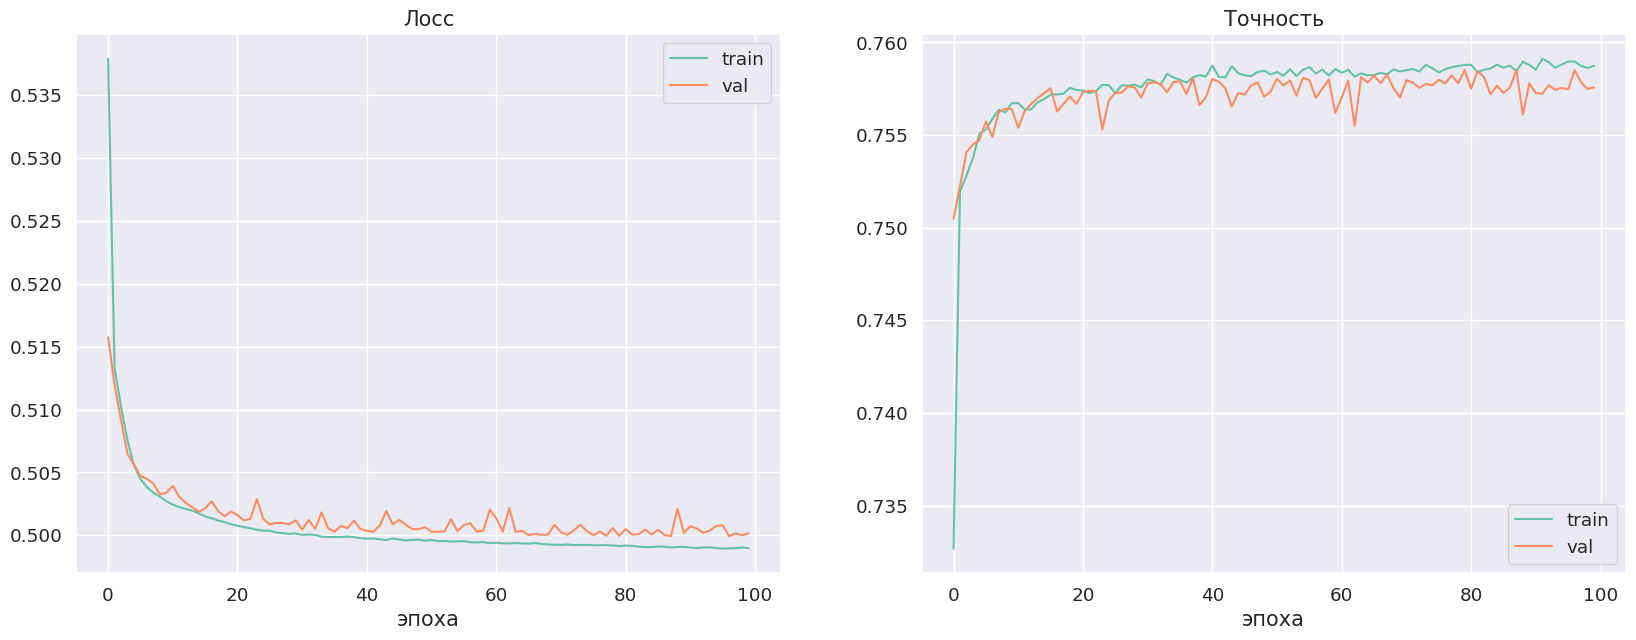

In [ ]:
plot_learning_curves(history)

Тестирование

In [ ]:
model.eval()
model.cpu()

SimpleModel(
  (linear1): Linear(in_features=13, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=2, bias=True)
)

In [ ]:
def test_epoch(model, criterion, X_test, y_test, device):

    model.eval()
    model.cpu()
    test_loss = 0
    test_acc = 0
    test_size = 0

    with torch.no_grad():

        X_test, y_test = X_test.to(device), y_test.to(device)
        logits = model(X_test)
        y_pred = torch.argmax(logits, axis=1).detach()
        test_acc += (y_test == y_pred).sum()

    return test_acc

In [ ]:
test_acc = test_epoch(model, criterion, X_test, y_test, device)

In [ ]:
accuracy = test_acc/len(X_test)

In [ ]:
print('точность:', accuracy.item())

точность: 0.7535187005996704


**Выводы:** На тестовой выборке точность достаточно высокая, точность на трейне, валидации и тесте сравнимая, очевидного переобучения/недообучения не происходит.